#IMPORTING LIBRARIES

In [1]:
from datetime import datetime
import numpy as np
from scipy import stats
from scipy import special
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import csv

In [2]:

def get_sts(data):
	res=np.amin(data,axis=0)#min
	res=np.reshape(res,(-1,res.shape[0]))

	res1=np.amax(data,axis=0)#max
	res1=np.reshape(res1,(-1,res1.shape[0]))
	res =np.concatenate((res,res1), axis=0)

	res1=np.mean(res,axis=0)#midrange
	res1=np.reshape(res1,(-1,res1.shape[0]))
	res =np.concatenate((res,res1), axis=0)

	res1=np.mean(data,axis=0)#mean
	res1=np.reshape(res1,(-1,res1.shape[0]))
	res =np.concatenate((res,res1), axis=0)

	med=np.median(data,axis=0)#median
	med=np.reshape(med,(-1,med.shape[0]))
	res =np.concatenate((res,med), axis=0)

	res1=stats.mstats.mode(data, axis=0)[0]#mode
	res1=np.reshape(res1,(1,-1))
	res =np.concatenate((res,res1), axis=0)

	fq=np.percentile(data,q=25,axis=0)#first quartile
	fq=np.reshape(fq,(-1,fq.shape[0]))
	res =np.concatenate((res,fq), axis=0)

	tq=np.percentile(data,q=75,axis=0)#third quartile
	tq=np.reshape(tq,(-1,tq.shape[0]))
	res =np.concatenate((res,tq), axis=0)
	
	res1=tq-fq#inter quartile range
	res =np.concatenate((res,res1), axis=0)
	
	res1=np.std(data,axis=0)#std
	res1=np.reshape(res1,(-1,res1.shape[0]))
	res =np.concatenate((res,res1), axis=0)

	res1=np.median(np.absolute(data-med), axis=0)#median_absolute_deviation
	res1=np.reshape(res1,(-1,res1.shape[0]))
	res =np.concatenate((res,res1), axis=0)

	res1=stats.skew(data, axis=0)#skewness
	res1=np.reshape(res1,(-1,res1.shape[0]))
	res =np.concatenate((res,res1), axis=0)

	res1=stats.kurtosis(data, axis=0, fisher=True)#skewness
	res1=np.reshape(res1,(-1,res1.shape[0]))
	res =np.concatenate((res,res1), axis=0)

	return res


In [3]:

def process_data(file_loc,starttimesecs,timewidth):
	f=open(file_loc)
	cur_end = starttimesecs+timewidth
	epoch = datetime.utcfromtimestamp(0)
	cur_arr=[]
	full_arr=[]
	tme_arr = []
	for line in f:
		line_arr=line.strip().split()
		tme="-".join(line_arr[:5])
		tme=datetime.strptime(tme, '%Y-%j-%H-%M-%S')
		dte=tme.strftime("%Y-%m-%d %H:%M:%S")
		tme=(tme - epoch).total_seconds()
		if tme>cur_end:
			tme_arr.append(dte)
			res=get_sts(np.array(cur_arr))
			full_arr.append(res)
			cur_end = cur_end+timewidth
			cur_arr=[]
		lst=line_arr[-4:]
		lst=list(map(float, lst))
		cur_arr.append(lst[:])

	tme_arr.append(dte)
	res=get_sts(np.array(cur_arr))
	full_arr.append(res)
	return full_arr,tme_arr


In [4]:
#program begins by loading the data set
file_loc='G:\Data\Data-Sat1.txt'
f=open(file_loc)
i=0
end=''
orbit_period=5400
for line in f:
	if i==0:
		start=line.strip().split()
		start="-".join(start[:5])
	end=line
	i=i+1
    
end=end.strip().split()
end="-".join(end[:5])
starttime=datetime.strptime(start, '%Y-%j-%H-%M-%S')
endtime=datetime.strptime(end, '%Y-%j-%H-%M-%S')
epoch = datetime.utcfromtimestamp(0)
starttimesecs=(starttime - epoch).total_seconds()
endtimesecs=(endtime - epoch).total_seconds()

processed_data,tme_arr=process_data(file_loc,starttimesecs,orbit_period)
processed_data=np.array(processed_data)
processed_data_list=np.dsplit(processed_data, 4)
OPVID_list=[]

In [17]:
#first line of data 
f=open(file_loc)
for line in f:
    line_arr=line.strip().split()
line_arr

['2019',
 '334',
 '22',
 '59',
 '55',
 '847',
 '58',
 '-0.0012909326',
 '0.0001373333',
 '-0.0017761767',
 '-0.0011535993']

In [5]:
# Evaluating OPVID score for each orbit using the given parameters for each timestamp
for param in processed_data_list:
	param = np.reshape(param,(param.shape[0],param.shape[1]))
	
	nbrs = NearestNeighbors(n_neighbors=11, algorithm='ball_tree').fit(param)
	distances, indices = nbrs.kneighbors(param)
	last_dist = np.hsplit(distances, distances.shape[1])[-1]
	distances = np.hstack(np.hsplit(distances, distances.shape[1])[1:])
	distances = distances/last_dist
	ID_score = np.log(distances)
	ID_score = np.reciprocal(np.sum(ID_score,axis=1)*-0.1)
	
	indices = np.hstack(np.hsplit(indices, indices.shape[1])[1:])
	IDOS = np.reshape(np.repeat(ID_score,ID_score.shape[0]),(ID_score.shape[0],-1)).T
	IDOS = np.reciprocal(np.take(IDOS,indices))
	IDOS = np.sum(IDOS,axis=1)
	IDOS = (ID_score/10)*IDOS

	PIDOS = np.reshape(np.repeat(ID_score,ID_score.shape[0]),(ID_score.shape[0],-1)).T
	PIDOS = np.take(PIDOS,indices)
	PIDOS = np.sum(PIDOS,axis=1)*0.1
	PIDOS = ID_score-PIDOS

	lmbda = 1.0 #scaling factor
	erf_pidos = np.reshape(np.repeat(ID_score,ID_score.shape[0]),(ID_score.shape[0],-1)).T
	erf_pidos = np.std(erf_pidos,axis=1)
	erf_pidos = PIDOS/(lmbda*erf_pidos*2**0.5)
	erf_pidos = special.erf(erf_pidos)
	erf_pidos = np.reshape(erf_pidos,(erf_pidos.shape[0],-1))
	erf_pidos = np.hstack((np.zeros(erf_pidos.shape),erf_pidos))
	OPVID=np.amax(erf_pidos,axis=1)
	OPVID_list.append(OPVID)

In [8]:
print(OPVID_list[:][0])

[0.13596862 0.         0.36846242 ... 0.         0.05750872 0.        ]


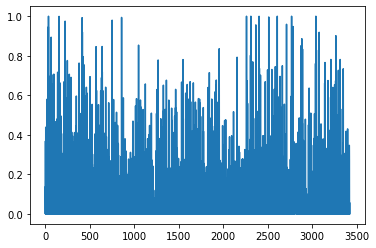

In [12]:
plt.plot(OPVID_list[:][0])

In [9]:
print(OPVID_list[:][1])

[0.52119807 0.         0.         ... 0.         0.         0.        ]


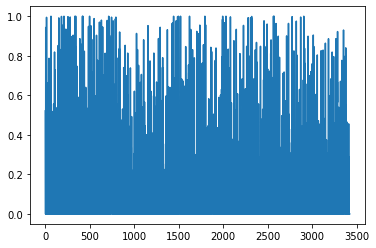

In [13]:
plt.plot(OPVID_list[:][1])

In [10]:
print(OPVID_list[:][2])

[0.         0.         0.         ... 0.21235909 0.         0.39208548]


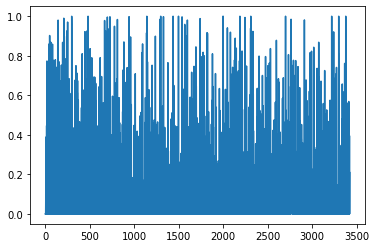

In [14]:
plt.plot(OPVID_list[:][2])

In [11]:
print(OPVID_list[:][3])

[0.         0.         0.37799232 ... 0.17580361 0.         0.        ]


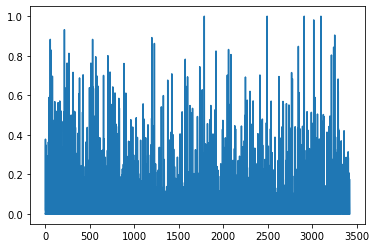

In [15]:
plt.plot(OPVID_list[:][3])